# Overvew
- ff1010 dataset をnocallデータセットとして、評価を行なう

# CONST

In [150]:
NB = '050'
DEBUG = False
PERIOD = 5
# PATH_EVENT = './../data_ignore/event/nb017_event_rms/nb017_event_rms.csv'
DATASET = '32khz'
DIR_MODEL = './../data_ignore/model'
DIR_NOCALL = './../data/external_dataset/ff1010bird_selection/wav_32000/'
# PATH_MODEL = './../data_ignore/model/resnest50/resnest50_fast_1s1x64d-d8fbf808.pth'
PATH_SECONDALY_LAVEL_CODE = '../data/external_dataset/secondaly_labels/codes.pkl'
TARGET_SR = 32000

In [9]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 45
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 20
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 5
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 5
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [344]:
import os
import gc
import pickle
import itertools
import typing as tp
import logging
import cv2 
import warnings
import math
import time
import yaml
import random
import librosa
import numpy as np
import pandas as pd
from glob import glob
import soundfile as sf
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from contextlib import contextmanager
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
# from torchvision import models
import torch.nn.functional as F
import torch.utils.data as data
# import resnest.torch as resnest_torch
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
from torch.nn.modules.utils import _pair

import sys
sys.path.insert(0, './../src/util/')
from const import BIRD_CODE, INV_BIRD_CODE

# My function

In [11]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore

@contextmanager
def timer(name: str, logger):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
        
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger

In [12]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [13]:
class SpectrogramDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
#         sr, y = wavfile.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels


In [14]:
class TestDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, clip: np.ndarray,
                 img_size=224, melspectrogram_parameters={}):
        self.df = df
        self.clip = clip
        self.img_size = img_size
        self.melspectrogram_parameters = melspectrogram_parameters
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        SR = 32000
        sample = self.df.loc[idx, :]
        site = sample.site
        row_id = sample.row_id
        
        if site == "site_3":
            y = self.clip.astype(np.float32)
            len_y = len(y)
            start = 0
            end = SR * 5
            images = []
            while len_y > start:
                y_batch = y[start:end].astype(np.float32)
                if len(y_batch) != (SR * 5):
                    break
                start = end
                end = end + SR * 5
                
                melspec = librosa.feature.melspectrogram(y_batch,
                                                         sr=SR,
                                                         **self.melspectrogram_parameters)
                melspec = librosa.power_to_db(melspec).astype(np.float32)
                image = mono_to_color(melspec)
                height, width, _ = image.shape
                image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
                image = np.moveaxis(image, 2, 0)
                image = (image / 255.0).astype(np.float32)
                images.append(image)
            images = np.asarray(images)
            return images, row_id, site
        else:
            end_seconds = int(sample.seconds)
            start_seconds = int(end_seconds - 5)
            
            start_index = SR * start_seconds
            end_index = SR * end_seconds
            
            y = self.clip[start_index:end_index].astype(np.float32)

            melspec = librosa.feature.melspectrogram(y, sr=SR, **self.melspectrogram_parameters)
            melspec = librosa.power_to_db(melspec).astype(np.float32)

            image = mono_to_color(melspec)
            height, width, _ = image.shape
            image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
            image = np.moveaxis(image, 2, 0)
            image = (image / 255.0).astype(np.float32)

            return image, row_id, site
        
def prediction_for_clip(test_df: pd.DataFrame, 
                        clip: np.ndarray, 
                        model, 
                        mel_params: dict, 
                        threshold=0.5):

    dataset = TestDataset(df=test_df, 
                          clip=clip,
                          img_size=224,
                          melspectrogram_parameters=mel_params)
    loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    prediction_dict = {}
    for image, row_id, site in loader:
        site = site[0]
        row_id = row_id[0]
        if site in {"site_1", "site_2"}:
            image = image.to(device)

            with torch.no_grad():
                prediction = model(image)
                proba = F.sigmoid(prediction).detach().cpu().numpy().reshape(-1)

            events = proba >= threshold
            labels = np.argwhere(events).reshape(-1).tolist()
            

        else:
            # to avoid prediction on large batch
            image = image.squeeze(0)
            batch_size = 16
            whole_size = image.size(0)
            if whole_size % batch_size == 0:
                n_iter = whole_size // batch_size
            else:
                n_iter = whole_size // batch_size + 1
                
            all_events = set()
            for batch_i in range(n_iter):
                batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
#                 if batch.ndim == 3:
#                     batch = batch.unsqueeze(0)

                batch = batch.to(device)
                with torch.no_grad():
                    prediction = model(batch)
                    proba = F.sigmoid(prediction).detach().cpu().numpy()              
                events = proba >= threshold
                for i in range(len(events)):
                    event = events[i, :]
                    labels = np.argwhere(event).reshape(-1).tolist()
                    for label in labels:
                        all_events.add(label)
                        
            labels = list(all_events)
        if len(labels) == 0:
            prediction_dict[row_id] = "nocall"
        else:
            labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
            label_string = " ".join(labels_str_list)
            prediction_dict[row_id] = label_string
    return prediction_dict

def prediction_mod(test_df: pd.DataFrame,
               mel_params: dict,
               model,
               threshold=0.5):
    
    unique_audio_id = test_df.audio_id.unique()

    warnings.filterwarnings("ignore")
    prediction_dfs = []
    for i in progress_bar(range(len(test_df))):
        audio_id = test_df['audio_id'].values[i]
        extension = '' if '.wav' in audio_id else '.mp3'
        clip, _ = librosa.load(test_df['file_path'].values[i],
                               sr=TARGET_SR,
                               mono=True,
                               res_type="kaiser_fast")
        
        test_df_for_audio_id = test_df.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        prediction_dict = prediction_for_clip(test_df_for_audio_id,
                                              clip=clip,
                                              model=model,
                                              mel_params=mel_params,
                                              threshold=threshold)
        row_id = list(prediction_dict.keys())
        birds = list(prediction_dict.values())
        prediction_df = pd.DataFrame({
            "row_id": row_id,
            "birds": birds
        })
        prediction_dfs.append(prediction_df)
    
    prediction_df = pd.concat(prediction_dfs, axis=0, sort=False).reset_index(drop=True)
    return prediction_df

In [15]:
def make_mask_images(melspec):

    len_mel = melspec.shape[1]
    hop_len = int(len_mel / int(MASK_NUM*2))
    mels = []
    
    start = 0
    end = start + int(len_mel / MASK_NUM)
    mels.append(melspec)
    while end < len_mel:
        mask_mel = np.zeros((melspec.shape[0], melspec.shape[1]), dtype=melspec.dtype)
        mask_mel[:,start:end] = melspec[:,start:end]
        start += hop_len
        end = start + int(len_mel / MASK_NUM)
        mels.append(mask_mel)
#         plot_spec(mask_mel)
    return mels

def signal_to_mel_with_mask(y, img_size):
    melspec = librosa.feature.melspectrogram(y,
                             sr=TARGET_SR,
                             fmin=20,
                             fmax=16000)
    mask_mels = make_mask_images(melspec)
    images = []
    for melspec in mask_mels:
        melspec = librosa.power_to_db(melspec).astype(np.float32)
        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * img_size / height), img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)
        images.append(image)
    return images

class TestDatasetStrideMask(data.Dataset):
    def __init__(self, df: pd.DataFrame, clip: np.ndarray,
                 img_size=224, melspectrogram_parameters={}):
        self.df = df
        self.clip = clip
        self.img_size = img_size
        self.melspectrogram_parameters = melspectrogram_parameters
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        SR = 32000
        sample = self.df.loc[idx, :]
        site = sample.site
        row_id = sample.row_id
        
        if site == "site_3":
            y = self.clip.astype(np.float32)
            len_y = len(y)
#             start = 0
#             end = SR * 5
            images = []
            effect_len = SR * PERIOD

            # 短い
            if(len_y < effect_len):
                for i in range(3):
                    new_y = np.zeros(effect_len, dtype=y.dtype)
                    start = np.random.randint(effect_len - len_y)
                    new_y[0:len(y)] = y
                    y = new_y.astype(np.float32)
                    image = signal_to_mel_with_mask(y, self.img_size)
                    images.extend(image)
            # 長い
            elif(len_y > effect_len):
                start = 0
                end = SR * PERIOD
                while len_y > start:
                    y_batch = y[start:end].astype(np.float32)
                    if len(y_batch) != (SR * PERIOD):
                        break
                    start = end
                    end = end + SR * PERIOD
                    image = signal_to_mel_with_mask(y_batch, self.img_size)
                    images.extend(image)
                    
                start = len(y) - SR * PERIOD
                end = len(y) 
                while 0 < start:
                    y_batch = y[start:end].astype(np.float32)
                    if len(y_batch) != (SR * PERIOD):
                        break
                    end = start
                    start = end - SR * PERIOD
                    image = signal_to_mel_with_mask(y_batch, self.img_size)
                    images.extend(image)
            # 同じ
            else:
                y = y.astype(np.float32)
                image = signal_to_mel_with_mask(y, self.img_size)
                images.extend(image)
            images = np.asarray(images)
            return images, row_id, site
        else:
            end_seconds = int(sample.seconds)
            start_seconds = int(end_seconds - 5)
            
            start_index = SR * start_seconds
            end_index = SR * end_seconds
            
            y = self.clip[start_index:end_index].astype(np.float32)
            image = signal_to_mel_with_mask(y, self.img_size)
            images = np.asarray(image)
            return images, row_id, site

def prediction_for_clip_stride_mask(test_df: pd.DataFrame, 
                        clip: np.ndarray, 
                        model, 
                        mel_params: dict, 
                        threshold=0.5):

    dataset = TestDatasetStrideMask(df=test_df, 
                          clip=clip,
                          img_size=224,
                          melspectrogram_parameters=mel_params)
    loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    prediction_dict = {}
    for image, row_id, site in loader:
        site = site[0]
        row_id = row_id[0]
        
        image = image.squeeze(0)
        batch_size = 16
        whole_size = image.size(0)
        if whole_size % batch_size == 0:
            n_iter = whole_size // batch_size
        else:
            n_iter = whole_size // batch_size + 1

        all_events = set()
        for batch_i in range(n_iter):
            batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
            if batch.ndim == 3:
                batch = batch.unsqueeze(0)

            batch = batch.to(device)
            with torch.no_grad():
                prediction = model(batch)
                proba = F.sigmoid(prediction).detach().cpu().numpy()              
            events = proba >= threshold
            for i in range(len(events)):
                event = events[i, :]
                labels = np.argwhere(event).reshape(-1).tolist()
                for label in labels:
                    all_events.add(label)

        labels = list(all_events)
        if len(labels) == 0:
            prediction_dict[row_id] = "nocall"
        else:
            labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
            label_string = " ".join(labels_str_list)
            prediction_dict[row_id] = label_string
    return prediction_dict


def prediction_stride_mask_mod(test_df: pd.DataFrame, 
                               mel_params: dict, 
                               model, 
                               threshold=0.5):
    
#     unique_audio_id = test_df.audio_id.unique()

    warnings.filterwarnings("ignore")
    prediction_dfs = []
#     for audio_id in unique_audio_id:
    for i in progress_bar(range(len(test_df))):
        audio_id = test_df['audio_id'].values[i]
        extension = '' if '.wav' in audio_id else '.mp3'
        clip, _ = librosa.load(test_df['file_path'].values[i],
                               sr=TARGET_SR,
                               mono=True,
                               res_type="kaiser_fast")
        
        test_df_for_audio_id = test_df.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        prediction_dict = prediction_for_clip_stride_mask(test_df_for_audio_id,
                                              clip=clip,
                                              model=model,
                                              mel_params=mel_params,
                                              threshold=threshold)
        row_id = list(prediction_dict.keys())
        birds = list(prediction_dict.values())
        prediction_df = pd.DataFrame({
            "row_id": row_id,
            "birds": birds
        })
        prediction_dfs.append(prediction_df)
    
    prediction_df = pd.concat(prediction_dfs, axis=0, sort=False).reset_index(drop=True)
    return prediction_df

In [16]:
def prediction_for_clip_joint_stride_mask(test_df: pd.DataFrame, 
                        clip: np.ndarray, 
                        model, 
                        mel_params: dict, 
                        threshold=0.5):

    dataset = TestDatasetStrideMask(df=test_df, 
                          clip=clip,
                          img_size=224,
                          melspectrogram_parameters=mel_params)
    loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    prediction_dict = {}
    for image, row_id, site in loader:
        site = site[0]
        row_id = row_id[0]
        
        image = image.squeeze(0)
        batch_size = 16
        whole_size = image.size(0)
        if whole_size % batch_size == 0:
            n_iter = whole_size // batch_size
        else:
            n_iter = whole_size // batch_size + 1

        all_events = set()
        nocall_flag = False
        
        if site in {"site_1", "site_2"}:
            #一枚目(全体)チェック
            batch = image[:1]
            if batch.to('cpu').detach().numpy().copy().ndim == 3:
                batch = batch.unsqueeze(0)
            batch = batch.to(device)
            with torch.no_grad():
                prediction = model(batch)
                prediction = F.sigmoid(prediction)
                proba = prediction.detach().cpu().numpy()
            nocall_proba = proba[0]
            nocall_event = nocall_proba >= 0.6
            nocall_label = np.argwhere(nocall_event).reshape(-1).tolist()
            if len(nocall_label) == 0:
                nocall_flag = True
    #         print(nocall_label)

        if nocall_flag == False:

            for batch_i in range(n_iter):
                batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
    #             print(batch.shape)
                if batch.to('cpu').detach().numpy().copy().ndim == 3:
                    batch = batch.unsqueeze(0)
                batch = batch.to(device)
                with torch.no_grad():
                    prediction = model(batch)
                    prediction = F.sigmoid(prediction)
                    proba = prediction.detach().cpu().numpy()
                    events = proba >= threshold
                    for i in range(len(events)):
                        event = events[i, :]
                        labels = np.argwhere(event).reshape(-1).tolist()
                        for label in labels:
                            all_events.add(label)
        

        labels = list(all_events)
        if len(labels) == 0:
            prediction_dict[row_id] = "nocall"
        else:
            labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
            label_string = " ".join(labels_str_list)
            prediction_dict[row_id] = label_string
    return prediction_dict

def prediction_joint_stride_mask(test_df: pd.DataFrame, 
                               mel_params: dict, 
                               model, 
                               threshold=0.5):
    
#     unique_audio_id = test_df.audio_id.unique()

    warnings.filterwarnings("ignore")
    prediction_dfs = []
#     for audio_id in unique_audio_id:
    for i in progress_bar(range(len(test_df))):
        audio_id = test_df['audio_id'].values[i]
        extension = '' if '.wav' in audio_id else '.mp3'
        clip, _ = librosa.load(test_df['file_path'].values[i],
                               sr=TARGET_SR,
                               mono=True,
                               res_type="kaiser_fast")
        
        test_df_for_audio_id = test_df.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        prediction_dict = prediction_for_clip_joint_stride_mask(test_df_for_audio_id,
                                              clip=clip,
                                              model=model,
                                              mel_params=mel_params,
                                              threshold=threshold)
        row_id = list(prediction_dict.keys())
        birds = list(prediction_dict.values())
        prediction_df = pd.DataFrame({
            "row_id": row_id,
            "birds": birds
        })
        prediction_dfs.append(prediction_df)
    
    prediction_df = pd.concat(prediction_dfs, axis=0, sort=False).reset_index(drop=True)
    return prediction_df

In [17]:
def prediction_for_clip_stride_mask_thre9(test_df: pd.DataFrame, 
                        clip: np.ndarray, 
                        model, 
                        mel_params: dict, 
                        threshold=0.5):

    dataset = TestDatasetStrideMask(df=test_df, 
                          clip=clip,
                          img_size=224,
                          melspectrogram_parameters=mel_params)
    loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    prediction_dict = {}
    for image, row_id, site in loader:
        site = site[0]
        row_id = row_id[0]
        
        image = image.squeeze(0)
        batch_size = 16
        whole_size = image.size(0)
        if whole_size % batch_size == 0:
            n_iter = whole_size // batch_size
        else:
            n_iter = whole_size // batch_size + 1

        all_events = set()
        all_events_loose = set()
        for batch_i in range(n_iter):
            batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
            if batch.to('cpu').detach().numpy().copy().ndim == 3:
                batch = batch.unsqueeze(0)

            batch = batch.to(device)
            with torch.no_grad():
                prediction = model(batch)
                prediction = F.sigmoid(prediction)

                proba = prediction.detach().cpu().numpy()

            events = proba >= 0.9
#             events_loose = proba >= threshold_loose
            events_loose = proba >= threshold
            for i in range(len(events)):
                event = events[i, :]
                labels = np.argwhere(event).reshape(-1).tolist()
                for label in labels:
                    all_events.add(label)
            
            for i in range(len(events_loose)):
                event_loose = events_loose[i, :]
                labels_loose = np.argwhere(event_loose).reshape(-1).tolist()
                for label in labels_loose:
                    all_events_loose.add(label)

        labels = list(all_events)
        labels_loose = list(all_events_loose)
        if len(labels) == 0:
            prediction_dict[row_id] = "nocall"
        else:
            labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels_loose))
            label_string = " ".join(labels_str_list)
            prediction_dict[row_id] = label_string
    return prediction_dict

def prediction_stride_mask_thre9(test_df: pd.DataFrame, 
                               mel_params: dict, 
                               model, 
                               threshold=0.5):
    
#     unique_audio_id = test_df.audio_id.unique()

    warnings.filterwarnings("ignore")
    prediction_dfs = []
#     for audio_id in unique_audio_id:
    for i in progress_bar(range(len(test_df))):
        audio_id = test_df['audio_id'].values[i]
        extension = '' if '.wav' in audio_id else '.mp3'
        clip, _ = librosa.load(test_df['file_path'].values[i],
                               sr=TARGET_SR,
                               mono=True,
                               res_type="kaiser_fast")
        
        test_df_for_audio_id = test_df.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        prediction_dict = prediction_for_clip_stride_mask_thre9(test_df_for_audio_id,
                                              clip=clip,
                                              model=model,
                                              mel_params=mel_params,
                                              threshold=threshold)
        row_id = list(prediction_dict.keys())
        birds = list(prediction_dict.values())
        prediction_df = pd.DataFrame({
            "row_id": row_id,
            "birds": birds
        })
        prediction_dfs.append(prediction_df)
    
    prediction_df = pd.concat(prediction_dfs, axis=0, sort=False).reset_index(drop=True)
    return prediction_df

In [302]:
def prediction_for_clip_thresholds(test_df, clip, model, mel_params):

    dataset = TestDataset(df=test_df, 
                          clip=clip,
                          img_size=224,
                          melspectrogram_parameters=mel_params)
    loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
#     prediction_dict = {}
    prediction_dict_list = []
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        prediction_dict = {}
        for image, row_id, site in loader:
            site = site[0]
            row_id = row_id[0]
            if site in {"site_1", "site_2"}:
                image = image.to(device)

                with torch.no_grad():
                    prediction = model(image)
                    proba = F.sigmoid(prediction).detach().cpu().numpy().reshape(-1)

                events = proba >= threshold
                labels = np.argwhere(events).reshape(-1).tolist()


            else:
                # to avoid prediction on large batch
                image = image.squeeze(0)
                batch_size = 16
                whole_size = image.size(0)
                if whole_size % batch_size == 0:
                    n_iter = whole_size // batch_size
                else:
                    n_iter = whole_size // batch_size + 1

                all_events = set()
                for batch_i in range(n_iter):
                    batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
    #                 if batch.ndim == 3:
    #                     batch = batch.unsqueeze(0)

                    batch = batch.to(device)
                    with torch.no_grad():
                        prediction = model(batch)
                        proba = F.sigmoid(prediction).detach().cpu().numpy()              
                    events = proba >= threshold
                    for i in range(len(events)):
                        event = events[i, :]
                        labels = np.argwhere(event).reshape(-1).tolist()
                        for label in labels:
                            all_events.add(label)

                labels = list(all_events)
            if len(labels) == 0:
                prediction_dict[row_id] = "nocall"
            else:
                labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
                label_string = " ".join(labels_str_list)
                prediction_dict[row_id] = label_string
        prediction_dict_list.append(prediction_dict)
    return prediction_dict_list

def prediction_for_clip_stride_mask_thresholds(test_df: pd.DataFrame, 
                        clip: np.ndarray, 
                        model, 
                        mel_params: dict):

    dataset = TestDatasetStrideMask(df=test_df, 
                          clip=clip,
                          img_size=224,
                          melspectrogram_parameters=mel_params)
    loader = data.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    prediction_dict_list = []
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        prediction_dict = {}
        for image, row_id, site in loader:
            site = site[0]
            row_id = row_id[0]

            image = image.squeeze(0)
            batch_size = 16
            whole_size = image.size(0)
            if whole_size % batch_size == 0:
                n_iter = whole_size // batch_size
            else:
                n_iter = whole_size // batch_size + 1

            all_events = set()
            for batch_i in range(n_iter):
                batch = image[batch_i * batch_size:(batch_i + 1) * batch_size]
                if batch.ndim == 3:
                    batch = batch.unsqueeze(0)

                batch = batch.to(device)
                with torch.no_grad():
                    prediction = model(batch)
                    proba = F.sigmoid(prediction).detach().cpu().numpy()              
                events = proba >= threshold
                for i in range(len(events)):
                    event = events[i, :]
                    labels = np.argwhere(event).reshape(-1).tolist()
                    for label in labels:
                        all_events.add(label)

            labels = list(all_events)
            if len(labels) == 0:
                prediction_dict[row_id] = "nocall"
            else:
                labels_str_list = list(map(lambda x: INV_BIRD_CODE[x], labels))
                label_string = " ".join(labels_str_list)
                prediction_dict[row_id] = label_string
        prediction_dict_list.append(prediction_dict)
    return prediction_dict_list


def prediction_thresholds(test_df: pd.DataFrame,
               mel_params: dict,
               model, mask_num):
    global MASK_NUM
    MASK_NUM = mask_num 
    unique_audio_id = test_df.audio_id.unique()

    warnings.filterwarnings("ignore")
#     prediction_dfs = []
    prediction_dfs_dict = {'01': [], '02': [], '03': [], '04': [], '05': [], '06': [], '07': [], '08': [], '09': []}
    for i in progress_bar(range(len(test_df))):
        audio_id = test_df['audio_id'].values[i]
        extension = '' if '.wav' in audio_id else '.mp3'
        clip, _ = librosa.load(test_df['file_path'].values[i],
                               sr=TARGET_SR,
                               mono=True,
                               res_type="kaiser_fast")
        
        test_df_for_audio_id = test_df.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        prediction_method = prediction_for_clip_thresholds if mask_num == None else prediction_for_clip_stride_mask_thresholds
        prediction_dict_list = prediction_method(test_df_for_audio_id,
                                              clip=clip,
                                              model=model,
                                              mel_params=mel_params)
        for j, prediction_dict in enumerate(prediction_dict_list):
            row_id = list(prediction_dict.keys())
            birds = list(prediction_dict.values())
            prediction_df = pd.DataFrame({
                "row_id": row_id,
                "birds": birds
            })
            prediction_dfs_dict[f'0{j+1}'].append(prediction_df)

    prediction_df_dict = {}
    for i in range(9):
        prediction_df = pd.concat(prediction_dfs_dict[f'0{i+1}'], axis=0, sort=False).reset_index(drop=True)
        prediction_df_dict[f'0{i+1}'] = prediction_df
        
    return prediction_df_dict

In [64]:
def row_wise_f1_score_micro(y_true, y_pred):
    """ author @shonenkov """
    F1 = []
    for preds, trues in zip(y_pred, y_true):
        TP, FN, FP = 0, 0, 0
        preds = preds.split()
        trues = trues.split()
        for true in trues:
            if true in preds:
                TP += 1
            else:
                FN += 1
        for pred in preds:
            if pred not in trues:
                FP += 1
        F1.append(2*TP / (2*TP + FN + FP))
    return np.mean(F1)

In [20]:
def get_loaders_for_training(dataset_class, args_dataset, args_loader, train_file_list, valid_file_list):
    # # make dataset
    train_dataset = dataset_class(train_file_list, **args_dataset)
    val_dataset = dataset_class(valid_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    valid_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, valid_loader

In [21]:
class SplAtConv2d(Module):
    """Split-Attention Conv2d
    """
    def __init__(self, in_channels, channels, kernel_size, stride=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, bias=True,
                 radix=2, reduction_factor=4,
                 rectify=False, rectify_avg=False, norm_layer=None,
                 dropblock_prob=0.0, **kwargs):
        super(SplAtConv2d, self).__init__()
        padding = _pair(padding)
        self.rectify = rectify and (padding[0] > 0 or padding[1] > 0)
        self.rectify_avg = rectify_avg
        inter_channels = max(in_channels*radix//reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels
        self.dropblock_prob = dropblock_prob
        if self.rectify:
            from rfconv import RFConv2d
            self.conv = RFConv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                                 groups=groups*radix, bias=bias, average_mode=rectify_avg, **kwargs)
        else:
            self.conv = Conv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                               groups=groups*radix, bias=bias, **kwargs)
        self.use_bn = norm_layer is not None
        if self.use_bn:
            self.bn0 = norm_layer(channels*radix)
        self.relu = ReLU(inplace=True)
        self.fc1 = Conv2d(channels, inter_channels, 1, groups=self.cardinality)
        if self.use_bn:
            self.bn1 = norm_layer(inter_channels)
        self.fc2 = Conv2d(inter_channels, channels*radix, 1, groups=self.cardinality)
        if dropblock_prob > 0.0:
            self.dropblock = DropBlock2D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            if torch.__version__ < '1.5':
                splited = torch.split(x, int(rchannel//self.radix), dim=1)
            else:
                splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited) 
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        if self.use_bn:
            gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            if torch.__version__ < '1.5':
                attens = torch.split(atten, int(rchannel//self.radix), dim=1)
            else:
                attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x
class DropBlock2D(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return nn.functional.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(Bottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv2d(
            group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """ResNet Variants
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, radix=1, groups=1, bottleneck_width=64,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 rectified_conv=False, rectify_avg=False,
                 avd=False, avd_first=False,
                 final_drop=0.0, dropblock_prob=0,
                 last_gamma=False, norm_layer=nn.BatchNorm2d):
        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first

        super(ResNet, self).__init__()
        self.rectified_conv = rectified_conv
        self.rectify_avg = rectify_avg
        if rectified_conv:
            from rfconv import RFConv2d
            conv_layer = RFConv2d
        else:
            conv_layer = nn.Conv2d
        conv_kwargs = {'average_mode': rectify_avg} if rectified_conv else {}
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False, **conv_kwargs)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        self.avgpool = GlobalAvgPool2d()
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    dropblock_prob=0.0, is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=1, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=2, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=dilation, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x
    
class DropBlock2D(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return nn.functional.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(Bottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv2d(
            group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """ResNet Variants
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, radix=1, groups=1, bottleneck_width=64,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 rectified_conv=False, rectify_avg=False,
                 avd=False, avd_first=False,
                 final_drop=0.0, dropblock_prob=0,
                 last_gamma=False, norm_layer=nn.BatchNorm2d):
        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first

        super(ResNet, self).__init__()
        self.rectified_conv = rectified_conv
        self.rectify_avg = rectify_avg
        if rectified_conv:
            from rfconv import RFConv2d
            conv_layer = RFConv2d
        else:
            conv_layer = nn.Conv2d
        conv_kwargs = {'average_mode': rectify_avg} if rectified_conv else {}
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False, **conv_kwargs)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        self.avgpool = GlobalAvgPool2d()
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    dropblock_prob=0.0, is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=1, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=2, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=dilation, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x

In [22]:
class ResNeSt(nn.Module):
    def __init__(self, params):
        super().__init__()
        num_classes = params['n_classes']
        self.classifier = ResNet(
            Bottleneck, [3, 4, 6, 3],
            radix=1, groups=1, bottleneck_width=64,
            deep_stem=True, stem_width=32, avg_down=True,
            avd=True, avd_first=True)

        state_dict = torch.load(
            f'../data_ignore/model/resnest50/'\
            'resnest50_fast_1s1x64d-d8fbf808.pth')
        self.classifier.load_state_dict(state_dict)

        del self.classifier.fc
        # # use the same head as the baseline notebook.
        self.classifier.fc = nn.Sequential(
            nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
            nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
            nn.Linear(1024, num_classes))
        device = torch.device("cuda")
        self.classifier.to(device)
        self.classifier.eval()

    def forward(self, x):
        x = self.classifier.conv1(x)
        x = self.classifier.bn1(x)
        x = self.classifier.relu(x)
        x = self.classifier.maxpool(x)

        x = self.classifier.layer1(x)
        x = self.classifier.layer2(x)
        x = self.classifier.layer3(x)
        x = self.classifier.layer4(x)

        x = self.classifier.avgpool(x)
# x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        if self.classifier.drop:
            x = self.classifier.drop(x)
        x = self.classifier.fc(x)

        multiclass_proba = F.softmax(x, dim=1)
        multilabel_proba = F.sigmoid(x)
#         return {
#             "logits": x,
#             "multiclass_proba": multiclass_proba,
#             "multilabel_proba": multilabel_proba
#         }
        return x

In [23]:
def get_model(args: tp.Dict):
    # # get resnest50_fast_1s1x64d
    model = ResNet(
        Bottleneck, [3, 4, 6, 3],
        radix=1, groups=1, bottleneck_width=64,
        deep_stem=True, stem_width=32, avg_down=True,
        avd=True, avd_first=True)
    
    state_dict = torch.load(args["trained_weights"])
    model.load_state_dict(state_dict)
    
    del model.fc
    # # use the same head as the baseline notebook.
    model.fc = nn.Sequential(
        nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, args["num_classes"]))
    
#     state_dict = torch.load(args["trained_weights"])
#     model.load_state_dict(state_dict)
    device = torch.device("cuda")
#     device = torch.device('cpu')
    model.to(device)
    model.eval()
    
    return model

def get_model_v2(args: tp.Dict):
    # # get resnest50_fast_1s1x64d
    model = ResNeSt(args)
    
    state_dict = torch.load(args["trained_weights"])
    model.load_state_dict(state_dict)
    
    
    
#     state_dict = torch.load(args["trained_weights"])
#     model.load_state_dict(state_dict)
    device = torch.device("cuda")
#     device = torch.device('cpu')
    model.to(device)
    model.eval()
    
    return model

# def get_model(args: tp.Dict):
#     model =getattr(resnest_torch, args["name"])(pretrained=args["params"]["pretrained"])
#     del model.fc
#     # # use the same head as the baseline notebook.
#     model.fc = nn.Sequential(
#         nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
#         nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
#         nn.Linear(1024, args["params"]["n_classes"]))
    
#     return model

# Preparation

settings

In [24]:
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 500

In [25]:
settings = yaml.safe_load(settings_str)
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

for k, v in settings.items():
    print("[{}]".format(k))
    print(v)
set_seed(settings["globals"]["seed"])

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 45, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}}
[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}
[loader]
{'train': {'batch_size': 5, 'shuffle': True, 'num_workers': 10, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 5, 'shuffle': False, 'num_workers': 10, 'pin_memory': True, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}
[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}
[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}
[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}


<br>

data path

In [26]:
root = Path.cwd().parent
input_ex_root = root / 'data_ignore/external_dataset' / DATASET
train_resampled_audio_dirs = [input_ex_root / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [27]:
train_resampled_audio_dirs

[PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-01'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-02'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-03'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-04')]

<br>

load data

In [28]:
train = pd.read_csv(train_resampled_audio_dirs[0] / "train_mod.csv")
with open(PATH_SECONDALY_LAVEL_CODE, mode='rb') as f:
    scd_labels = pickle.load(f)

# Execution

<br>

train_all を作成  
train_all: リサンプル後のファイルパスなどを追加

In [29]:
tmp_list = []
for audio_d in train_resampled_audio_dirs:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for i, wav_f in enumerate(ebird_d.iterdir()):
            bool_n_splits = i==settings['split']['params']['n_splits']
            if bool_n_splits and DEBUG: break  # if DEBUG=True: 1bird/n_splits file
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

if DEBUG: print('----- debug mode -----')
print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


In [30]:
train_all['secondary_labels_code'] = scd_labels

<br>

fold

In [31]:
skf = StratifiedKFold(**settings["split"]["params"])

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id

In [32]:
use_fold = settings["globals"]["use_fold"]
idx_train = train_all['fold']!=use_fold
idx_valid = train_all['fold']==use_fold
df_valid = train_all[idx_valid]
train_file_list = train_all[idx_train][['file_path', 'ebird_code']].values.tolist()
valid_file_list = train_all[idx_valid][['file_path', 'ebird_code']].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(valid_file_list)))

[fold 0] train: 17100, val: 4275


In [33]:
len(train_file_list)+len(valid_file_list)

21375

In [34]:
device = torch.device('cuda')

<br>

**<font color='orange'> -------------------- settings ------------------ </font>**

**<font color='orange'> ------------------------------------------------ </font>**

In [35]:
# # # get loader
train_loader, valid_loader = get_loaders_for_training(
    SpectrogramDataset,
    settings["dataset"]["params"], settings["loader"], train_file_list, valid_file_list)

In [36]:
def get_epoch_loss_score(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    y_pred_list = []
    y_true_list = []
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
        
#         out_numpy = output.detach().cpu().numpy()
        _y_pred = output.detach().cpu().numpy().argmax(axis=1)
        y_pred_list.append(_y_pred)
        _y_true = target.detach().cpu().numpy().argmax(axis=1)
        y_true_list.append(_y_true)
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    y_pred = np.concatenate(y_pred_list, axis=0)
    y_true = np.concatenate(y_true_list, axis=0)
    f_score = f1_score(y_true, y_pred, average='macro')
    del data
    return loss, f_score

In [37]:
# # # get optimizer
# optimizer = getattr(
#         torch.optim, settings["optimizer"]["name"]
#         )(model.parameters(), **settings["optimizer"]["params"])

# # # # get scheduler
# scheduler = getattr(
#     torch.optim.lr_scheduler, settings["scheduler"]["name"]
#     )(optimizer, **settings["scheduler"]["params"])

# # # get loss
loss_func = getattr(nn, settings["loss"]["name"])(**settings["loss"]["params"])

# Evaluate

In [38]:
melspectrogram_parameters = {
    "n_mels": 128,
    "fmin": 20,
    "fmax": 16000
}

logger = get_logger()
set_seed(1213)

2020-09-13 17:36:54,567 - INFO - logger set up


<br>

**nocall dataset**

In [77]:
file_path = sorted(glob(f'{DIR_NOCALL}/*'))
row_id_list = [os.path.basename(file_path[i]) for i in range(len(file_path))]

df_valid_nocall = pd.DataFrame()
df_valid_nocall['row_id'] = row_id_list
df_valid_nocall['site'] = 'site_1'
df_valid_nocall['seconds'] = 5
df_valid_nocall['audio_id'] = row_id_list
df_valid_nocall['file_path'] = file_path
df_valid_nocall['all_bird'] = 'nocall'

<br>

**site3 dataset(長い、複数羽)**

In [40]:
df_valid_site3 = pd.DataFrame()
for i in range(len(df_valid)):
    _df = df_valid['secondary_labels_code']
    lbl = _df.values[i]
    if (lbl != [-1]) & (lbl != [264]):
        if not 264 in lbl:
            df_valid_site3 = df_valid_site3.append(df_valid.iloc[[i], :])
df_valid_site3 = df_valid_site3.reset_index(drop=True)
df_valid_site3['audio_id'] = df_valid_site3['filename']
df_valid_site3['row_id'] = df_valid_site3['filename']
df_valid_site3['site'] = 'site_3'

In [41]:
all_bird_list = []
for i in range(len(df_valid_site3)):
    primary_label = df_valid_site3['ebird_code'][i]
    scd_list = df_valid_site3['secondary_labels_code'][i]
    all_bird = primary_label
    for scd in scd_list:
        bird_code = INV_BIRD_CODE[scd]
        all_bird = all_bird + ' ' + bird_code
    all_bird_list.append(all_bird)
df_valid_site3['all_bird'] = all_bird_list

<br>

**1bird dataset(短い、1羽)**

In [42]:
df_valid_1bird = pd.DataFrame()
for i in range(len(df_valid)):
    _df = df_valid['secondary_labels_code']
    lbl = _df.values[i]
    duration = df_valid['duration'].values[i]
    if (lbl != [-1]) & (lbl != [264]):
        pass
    elif duration < 7:
        df_valid_1bird = df_valid_1bird.append(df_valid.iloc[[i], :])

df_valid_1bird['audio_id'] = df_valid_1bird['filename']
df_valid_1bird['row_id'] = df_valid_1bird['filename']
df_valid_1bird['site'] = 'site_1'
df_valid_1bird['seconds'] = 5
df_valid_1bird['all_bird'] = df_valid_1bird['ebird_code']

<br>

**some birds dataset(短い、複数羽)**

In [467]:
df_valid_some_bird = df_valid_site3[df_valid_site3.copy()['duration'] < 10]
df_valid_some_bird['site'] = 'site_1'
df_valid_some_bird['seconds'] = 5

---

In [468]:
len(df_valid_nocall), len(df_valid_1bird[::3]), len(df_valid_some_bird), len(df_valid_site3[::20]), 

(251, 119, 81, 44)

In [523]:
def evaluate_model(model, prediction_method, threshold, mask_num):
    df_dict = {
        'nocall': df_valid_nocall,
        '1bird': df_valid_1bird[::3],
        'some_bird': df_valid_some_bird,
#         'site3': df_valid_site3[::20],
    }
    
    global MASK_NUM
    MASK_NUM = mask_num 
#     if mask_num == None:
#         prediction_method = prediction_mod
#     else:
#         global MASK_NUM
#         prediction_method = prediction_joint_stride_mask
# #         prediction_method = prediction_stride_mask_mod
    
    df_score = pd.DataFrame()
    sub_dict = {}
    for key in df_dict.keys():
        df = df_dict[key][::1]
        sub = prediction_method(test_df=df, model=model,
                            mel_params=melspectrogram_parameters, threshold=threshold)
        sub_dict[key] = sub
        score = row_wise_f1_score_micro(df['all_bird'], sub['birds'])
        df_score[key] = [score]
    return df_score, sub_dict

def evaluate_model_thresholds(model, mask_num, run_name):
    df_dict = {
        'nocall': df_valid_nocall,
        '1bird': df_valid_1bird[::3],
        'some_bird': df_valid_some_bird,
#         'site3': df_valid_site3[::20],
    }
    
    df_score = pd.DataFrame({
        'run_name': [run_name] * 9,
        'threshold': np.arange(1, 9+1)/10
    })
    thre_dict = {}
    score_thre_list_dict = {}
    for key in df_dict.keys():
        df = df_dict[key][::1]
        sub_thre_dict = prediction_thresholds(test_df=df, model=model,
                            mel_params=melspectrogram_parameters, mask_num=mask_num)
        score_list = []
        for i in range(9):
            sub_thre = sub_thre_dict[f'0{i+1}']
            score = row_wise_f1_score_micro(df['all_bird'], sub_thre['birds'])
            score_list.append(score)
        df_score[key] = score_list
    return df_score

# Conpare

## model baseline
- thre: 0.6
- LB: 0.563

In [524]:
model_path = './../data_ignore/hydra_outputs/2020-09-06/19-56-52/try0/ResNeSt_fold0.pth'
model_config = {
    "base_model_name": "resnest50_fast_1s1x64d",
    "pretrained": False,
    "n_classes": 264,
    "trained_weights": model_path,
}
model = get_model_v2(model_config)

model = model.to(device)
print(f'model name: {model.__class__.__name__}')

model name: ResNeSt


In [525]:
submission_dict = {
    'baseline': {'LB': 0.563, 'sub_thre': 0.6,    'mask_num':None, 'result_df': None},
    'mask3_thre8': {'LB': 0.554, 'sub_thre': 0.8, 'mask_num':3, 'result_df': None},
    'mask2_thre5': {'LB': 0.537, 'sub_thre': 0.5, 'mask_num':2, 'result_df': None},
    'mask3_thre9': {'LB': 0.560, 'sub_thre': 0.9, 'mask_num':3, 'result_df': None},
}

In [526]:
for key in submission_dict.keys():
    sub = submission_dict[key]
    mask_num = sub['mask_num']
    df = evaluate_model_thresholds(model, mask_num=mask_num, run_name=key)
    sub['result_df'] = df
    print(f'\n {key}')
    display(df)


 baseline


,run_name,threshold,nocall,1bird,some_bird
0,baseline,0.1,0.243028,0.675070,0.482951
1,baseline,0.2,0.545817,0.665266,0.477366
2,baseline,0.3,0.693227,0.658263,0.460082
3,baseline,0.4,0.808765,0.638655,0.431687
4,baseline,0.5,0.860558,0.624650,0.411111
5,baseline,0.6,0.888446,0.591036,0.402058
6,baseline,0.7,0.928287,0.560224,0.375309
7,baseline,0.8,0.956175,0.518207,0.346502
8,baseline,0.9,0.972112,0.462185,0.284774



 mask3_thre8


,run_name,threshold,nocall,1bird,some_bird
0,mask3_thre8,0.1,0.019920,0.395052,0.359087
1,mask3_thre8,0.2,0.183267,0.490823,0.429496
2,mask3_thre8,0.3,0.382470,0.523810,0.462787
3,mask3_thre8,0.4,0.569721,0.567507,0.481354
4,mask3_thre8,0.5,0.681275,0.596639,0.476896
5,mask3_thre8,0.6,0.737052,0.607843,0.473956
6,mask3_thre8,0.7,0.796813,0.591036,0.453792
7,mask3_thre8,0.8,0.876494,0.584034,0.435802
8,mask3_thre8,0.9,0.916335,0.529412,0.399177



 mask2_thre5


,run_name,threshold,nocall,1bird,some_bird
0,mask2_thre5,0.1,0.059761,0.538455,0.432396
1,mask2_thre5,0.2,0.239044,0.597199,0.484274
2,mask2_thre5,0.3,0.430279,0.624370,0.488536
3,mask2_thre5,0.4,0.605578,0.635014,0.498765
4,mask2_thre5,0.5,0.705179,0.656022,0.501235
5,mask2_thre5,0.6,0.780876,0.633613,0.482305
6,mask2_thre5,0.7,0.844622,0.628011,0.455144
7,mask2_thre5,0.8,0.888446,0.602241,0.439918
8,mask2_thre5,0.9,0.928287,0.535014,0.367901



 mask3_thre9


,run_name,threshold,nocall,1bird,some_bird
0,mask3_thre9,0.1,0.019920,0.395052,0.359087
1,mask3_thre9,0.2,0.183267,0.490823,0.429496
2,mask3_thre9,0.3,0.382470,0.523810,0.462787
3,mask3_thre9,0.4,0.569721,0.567507,0.481354
4,mask3_thre9,0.5,0.681275,0.596639,0.476896
5,mask3_thre9,0.6,0.737052,0.607843,0.473956
6,mask3_thre9,0.7,0.796813,0.591036,0.453792
7,mask3_thre9,0.8,0.876494,0.584034,0.435802
8,mask3_thre9,0.9,0.916335,0.529412,0.399177


In [527]:
def calc_all_score(nocall, _1bird, some_bird, nocall_reduction, some_bird_ratio):
    score = 0.544*nocall*nocall_reduction + ((1-0.544)*(1-some_bird_ratio))*_1bird + ((1-0.544)*some_bird_ratio)*some_bird
    return score
# base = calc_all_score(         0.8884, 0.5910, 0.402)
# balance = calc_all_score(      0.872510, 0.610, 0.400)
# balance_multi = calc_all_score(0.912351, 0.62465, 0.397942)
# balance_short = calc_all_score(0.816733, 0.6190, 0.374897)
# print(base, balance, balance_multi, balance_short)

In [557]:
step = 0.01
nocall_reductions = np.arange(0.05, 1, step)
some_bird_ratios = np.arange(0.05, 1, step)
df_param_grid = pd.DataFrame()
for nocall_reduction, some_bird_ratio in progress_bar(list(itertools.product(nocall_reductions, some_bird_ratios))):
    sum_distance = 0
    for key in submission_dict.keys():
        sub = submission_dict[key]
        mask_num = sub['mask_num']
        sub_thre = sub['sub_thre']
        lb = sub['LB']
        df = sub['result_df']

        mask = df['threshold'] == sub_thre
        nocall = df[mask].nocall.values[0]
        _1bird = df[mask]['1bird'].values[0]
        some_bird = df[mask].some_bird.values[0]
        all_score = calc_all_score(nocall, _1bird, some_bird, nocall_reduction, some_bird_ratio)
        sum_distance += (lb - all_score)**2
    _df = pd.DataFrame({
        'nocall_reduction': [nocall_reduction],
        'some_bird_ratio': [some_bird_ratio],
        'distance': [sum_distance],
    })
    df_param_grid = df_param_grid.append(_df)
df_param_grid = df_param_grid.reset_index(drop=True)

In [558]:
# get best param
idx_best = df_param_grid['distance'].argmin()
best_nocall_reduction = df_param_grid['nocall_reduction'][idx_best]
best_some_bird_ratio = df_param_grid['some_bird_ratio'][idx_best]
print('best_idx', idx_best)
print('best_nocall_reductioin', best_nocall_reduction)
print('best_some_bird', best_some_bird_ratio)

best_idx 5919
best_nocall_reductioin 0.6700000000000002
best_some_bird 0.34


In [570]:
mask = df_param_grid['distance'] < 0.00013
print(np.sum(mask))
display(df_param_grid[mask])

8


,nocall_reduction,some_bird_ratio,distance
5817,0.66,0.27,0.000127
5818,0.66,0.28,0.000126
5819,0.66,0.29,0.000128
5918,0.67,0.33,0.000128
5919,0.67,0.34,0.000125
5920,0.67,0.35,0.000126
6020,0.68,0.40,0.000130
6021,0.68,0.41,0.000129


<br>

best param を使って計算

baseline,	 0.563,	0.5640342081674341
mask3_thre8,	 0.554,	0.5628021129500052
mask2_thre5,	 0.537,	0.5321716566290086
mask3_thre9,	 0.56,	0.5552058171381288


Text(0, 0.5, 'all_score')

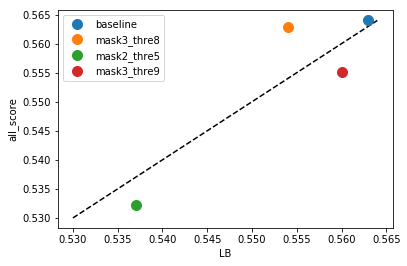

In [560]:
plt.plot(v, v, 'black', linestyle='--')
for key in submission_dict.keys():
    sub = submission_dict[key]
    sub_thre = sub['sub_thre']
    lb = sub['LB']
    df = sub['result_df']

    mask = df['threshold'] == sub_thre
    nocall = df[mask].nocall.values[0]
    _1bird = df[mask]['1bird'].values[0]
    some_bird = df[mask].some_bird.values[0]
    all_score = calc_all_score(nocall, _1bird, some_bird, best_nocall_reduction, best_some_bird_ratio)
    print(f'{key},\t {lb},\t{all_score}')
    plt.plot(lb, all_score, 'o', label=key, markersize=10)
v = [0.53, 0.564]
plt.legend()
plt.xlabel('LB')
plt.ylabel('all_score')

<br>

best param を使って、すべてのall_scoreを計算

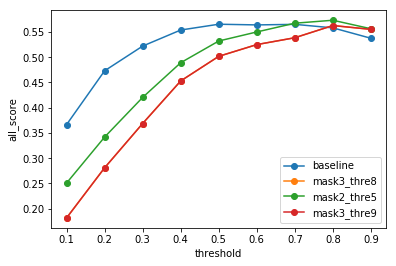

,run_name,threshold,nocall,1bird,some_bird,all_score
0,baseline,0.1,0.243028,0.675070,0.482951,0.366625
1,baseline,0.2,0.545817,0.665266,0.477366,0.473169
2,baseline,0.3,0.693227,0.658263,0.460082,0.522109
3,baseline,0.4,0.808765,0.638655,0.431687,0.553917
4,baseline,0.5,0.860558,0.624650,0.411111,0.565389
5,baseline,0.6,0.888446,0.591036,0.402058,0.564034
6,baseline,0.7,0.928287,0.560224,0.375309,0.565135
7,baseline,0.8,0.956175,0.518207,0.346502,0.558188
8,baseline,0.9,0.972112,0.462185,0.284774,0.537566
0,mask3_thre8,0.1,0.019920,0.395052,0.359087,0.181828


In [598]:
df_concat = pd.DataFrame()
for key in submission_dict.keys():
    sub = submission_dict[key]
    df = sub['result_df']
    thres = df['threshold']
    scores = []
    for i in range(len(df)):
        nocall = df['nocall'].values[i]
        _1bird = df['1bird'].values[i]
        some_bird = df['some_bird'].values[i]
        all_score = calc_all_score(nocall, _1bird, some_bird, best_nocall_reduction, best_some_bird_ratio)
        scores.append(all_score)
    plt.plot(thres, scores, '-o', label=key)
    df['all_score'] = scores
    df_concat = df_concat.append(df)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('all_score')
plt.show()
df_concat

In [602]:
df_concat.sort_values('all_score', ascending=False).iloc[:10, :]

,run_name,threshold,nocall,1bird,some_bird,all_score
7,mask2_thre5,0.8,0.888446,0.602241,0.439918,0.573276
6,mask2_thre5,0.7,0.844622,0.628011,0.455144,0.567419
4,baseline,0.5,0.860558,0.624650,0.411111,0.565389
6,baseline,0.7,0.928287,0.560224,0.375309,0.565135
5,baseline,0.6,0.888446,0.591036,0.402058,0.564034
7,mask3_thre9,0.8,0.876494,0.584034,0.435802,0.562802
7,mask3_thre8,0.8,0.876494,0.584034,0.435802,0.562802
7,baseline,0.8,0.956175,0.518207,0.346502,0.558188
8,mask2_thre5,0.9,0.928287,0.535014,0.367901,0.556399
8,mask3_thre9,0.9,0.916335,0.529412,0.399177,0.555206


---> mask2 かつ thre8 がよさそう

# ============================

balanced

In [603]:
model_path = './../data_ignore/hydra_outputs/2020-09-08/23-17-08/try0/ResNeSt_fold0.pth'
model_config = {
    "base_model_name": "resnest50_fast_1s1x64d",
    "pretrained": False,
    "n_classes": 264,
    "trained_weights": model_path,
}
model = get_model_v2(model_config)

model = model.to(device)
print(f'model name: {model.__class__.__name__}')

model name: ResNeSt


In [607]:
mask_num = None
run_name = 'balanced'

df = evaluate_model_thresholds(model, mask_num=mask_num, run_name=run_name)
sub['result_df'] = df
print(f'\n {key}')
display(df)


 mask3_thre9


,run_name,threshold,nocall,1bird,some_bird
0,balanced,0.1,0.223108,0.652661,0.445414
1,balanced,0.2,0.505976,0.655462,0.431335
2,balanced,0.3,0.701195,0.647059,0.423104
3,balanced,0.4,0.800797,0.641457,0.425162
4,balanced,0.5,0.848606,0.638655,0.407055
5,balanced,0.6,0.912351,0.624650,0.397942
6,balanced,0.7,0.932271,0.571429,0.377366
7,balanced,0.8,0.960159,0.537815,0.340329
8,balanced,0.9,0.968127,0.462185,0.295062


In [608]:
submission_dict[run_name] = {'LB': 0.531, 'sub_thre': 0.6, 'mask_num': mask_num, 'result_df': df}

<br>

balanced_multi_random

In [610]:
model_path = './../data_ignore/hydra_outputs/2020-09-09/22-57-25/try0/ResNeSt_fold0.pth'
model_config = {
    "base_model_name": "resnest50_fast_1s1x64d",
    "pretrained": False,
    "n_classes": 264,
    "trained_weights": model_path,
}
model = get_model_v2(model_config)

model = model.to(device)
print(f'model name: {model.__class__.__name__}')

model name: ResNeSt


In [ ]:
mask_num = None
run_name = 'balanced_multi_random'

df = evaluate_model_thresholds(model, mask_num=mask_num, run_name=run_name)
sub['result_df'] = df
print(f'\n {key}')
display(df)

In [ ]:
submission_dict[run_name] = {'LB': 0.531, 'sub_thre': 0.6, 'mask_num': mask_num, 'result_df': df}